In [85]:
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm,trange
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
path_csvs = r"F:\archive\data_eeg_age_v1\data2kaggle\train"
arr = []
y = []
for csv in tqdm(os.listdir(path_csvs)):
    csv_path = os.path.join(path_csvs,csv)
    df_tmp = pd.read_csv(csv_path,nrows=100)
    text = df_tmp.columns[0]
    match = re.search(r'(\d+)', text)
    if match:
        number_str = match.group(1)
        age = int(number_str)
    df1 = pd.read_csv(
        csv_path,
        comment='#',            
        sep = ',',
        nrows=100,
        header=None             
    )
    arr1 = df1.iloc[0,:]

    if len(arr1)==36:
        arr.append(arr1)
        y.append(age)
y = np.array(y)
ar = np.stack(arr)[:,:-4]
ar = (ar - np.mean(ar, axis=0)) / np.std(ar, axis=0)
print(ar.shape)
y = np.array(y>50,dtype=np.int8)
print(y.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 1171/1171 [00:44<00:00, 26.22it/s]

(609, 32)
(609,)


In [25]:
def simulate_labels_logistic(X, pi1=0.2, delta=0.5, noise_sd=1.0, seed=0):
    rng = np.random.default_rng(seed)
    n, m = X.shape
    m1 = int(np.round(pi1*m))
    idx_true = rng.choice(m, size=m1, replace=False)
    true_mask = np.zeros(m, dtype=bool)
    true_mask[idx_true] = True

    beta = np.zeros(m)
    beta[true_mask] = delta

    noise = rng.normal(0, noise_sd, size=n)
    logits = X @ beta + noise
    p = 1 / (1 + np.exp(-logits))
    y = rng.binomial(1, p)
    return y, true_mask, beta

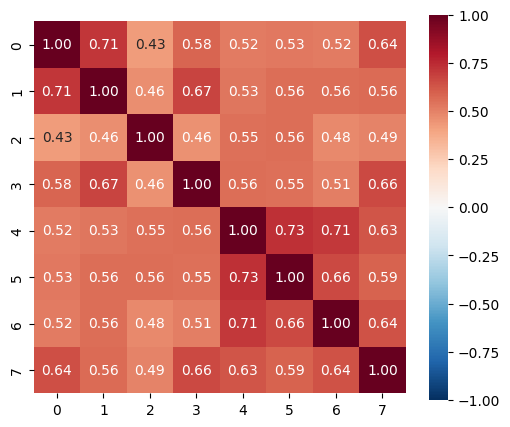

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit 
def plot_correlation_heatmap(data, title=""):
    corr_mat = np.corrcoef(data, rowvar=False)
    plt.figure(figsize=(6,5))
    sns.heatmap(corr_mat, vmin=-1, vmax=1, cmap="RdBu_r",
                square=True, annot=True, fmt=".2f")
    plt.title(title)
    plt.show()
plot_correlation_heatmap(ar[:,:8])

In [85]:
import pandas as pd
df1 = pd.read_csv(r"F:\age_predictions_cleaned.csv")
plot_correlation_heatmap(df1.iloc[:,:-1],' ')

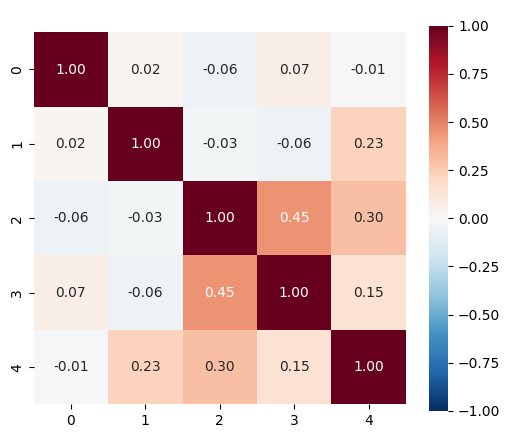

In [86]:
plot_correlation_heatmap(df1.iloc[:,:-1],' ')

In [87]:
X1 = np.array(df1.iloc[:,:-1])
y1 = np.array(df1.iloc[:,-1])
X2 = ar
y2 = y

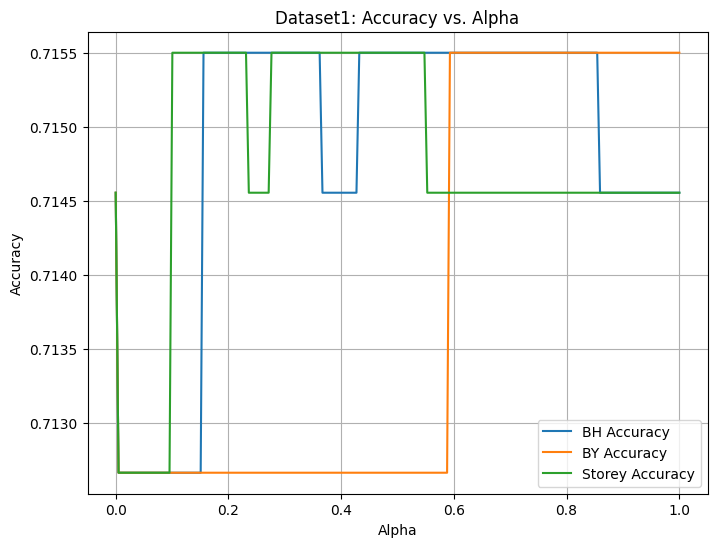

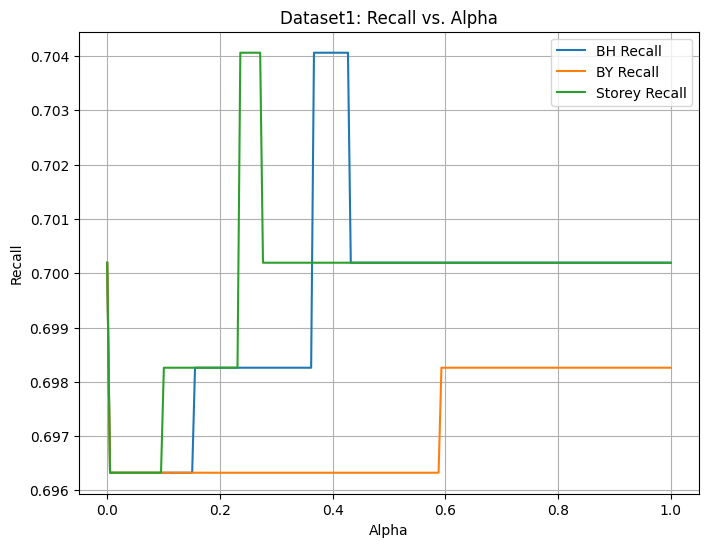

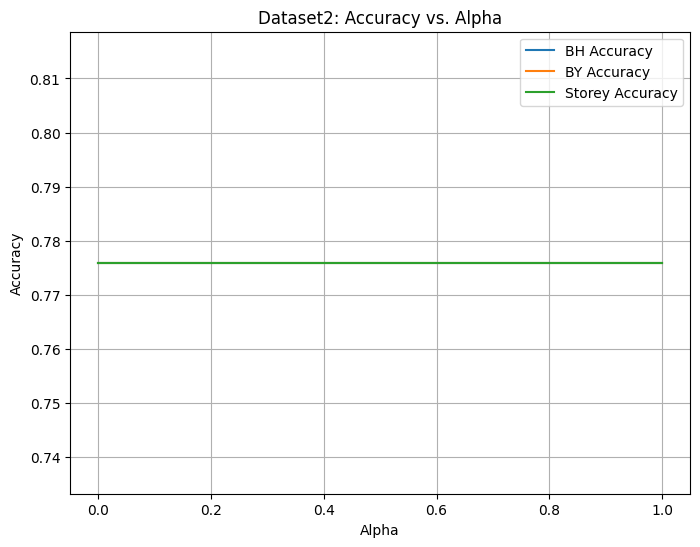

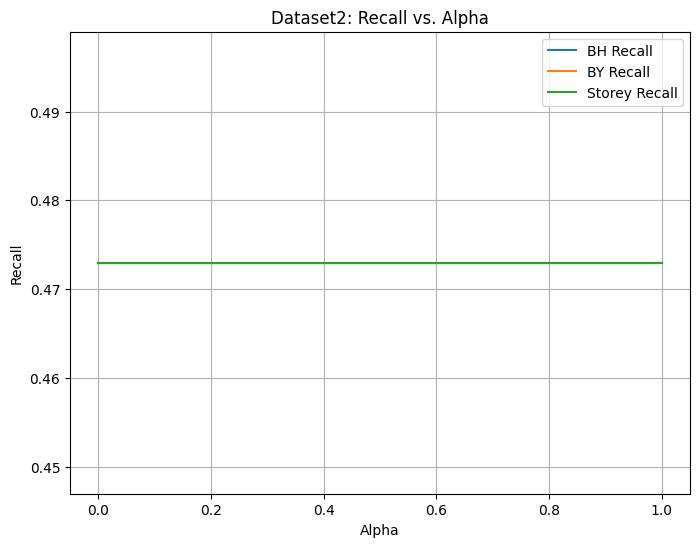

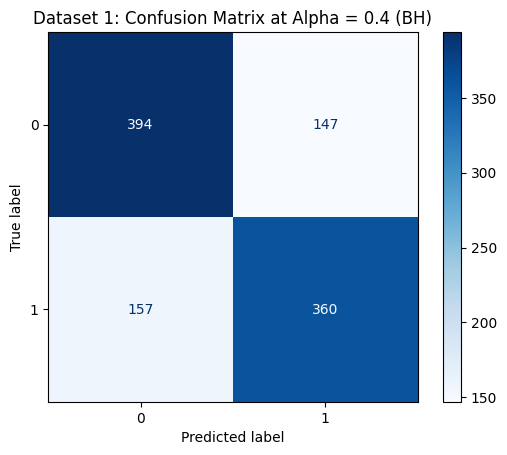

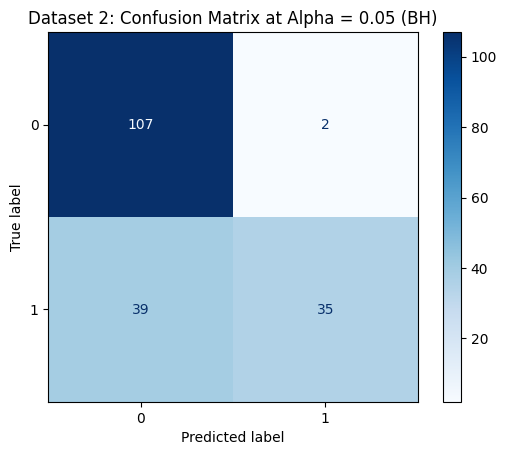

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

def logistic_regression_pvalues(X, y):
    pvals = []
    n_features = X.shape[1]
    for i in range(n_features):
        Xi = X[:, i]
        Xi_const = sm.add_constant(Xi)
        try:
            model = sm.Logit(y, Xi_const).fit(disp=0)
            pval = model.pvalues[1]  
        except Exception as e:
            pval = 1.0
        pvals.append(pval)
    return np.array(pvals)

def storey_qvalues(pvals, lambda_val=0.5):
    pvals = np.array(pvals)
    n = len(pvals)
    pi0 = np.mean(pvals > lambda_val) / (1.0 - lambda_val)
    pi0 = min(pi0, 1.0)
    sort_idx = np.argsort(pvals)
    sort_pvals = pvals[sort_idx]
    qvals = np.zeros(n)
    running_min = 1.0
    for i in range(n-1, -1, -1):
        q = (pi0 * n * sort_pvals[i]) / (i+1)
        running_min = min(running_min, q)
        qvals[sort_idx[i]] = running_min
    return qvals

def get_selected_features(X_train, y_train, alpha, method='BH'):
    pvals = logistic_regression_pvalues(X_train, y_train)
    if method == 'BH':
        reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
    elif method == 'BY':
        reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method='fdr_by')
    elif method == 'Storey':
        qvals = storey_qvalues(pvals, lambda_val=0.5)
        reject = qvals < alpha
        pvals_corr = qvals  
    else:
        raise ValueError("Unknown method: choose 'BH', 'BY', or 'Storey'")
    selected = np.where(reject)[0]
    return selected, pvals, pvals_corr


def evaluate_dataset_methods(X, y, alphas, methods=['BH', 'BY', 'Storey']):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    results = {}
    for m in methods:
        acc_list = []
        rec_list = []
        for alpha in alphas:
            selected, pvals, pvals_corr = get_selected_features(X_train, y_train, alpha, method=m)
            if len(selected) == 0:
                selected = np.arange(X_train.shape[1])
            model = LogisticRegression(solver='liblinear')
            model.fit(X_train[:, selected], y_train)
            y_pred = model.predict(X_test[:, selected])
            acc_list.append(accuracy_score(y_test, y_pred))
            rec_list.append(recall_score(y_test, y_pred))
        results[m] = {'accuracy': acc_list, 'recall': rec_list}
    return results, (X_train, X_test, y_train, y_test)


np.random.seed(0)
X1 = np.concatenate((X1,np.random.randn(len(X1),5)),axis=1)

alphas = np.linspace(0, 1, 200)

results1, split1 = evaluate_dataset_methods(X1, y1, alphas, methods=['BH', 'BY', 'Storey'])
results2, split2 = evaluate_dataset_methods(X2, y2, alphas, methods=['BH', 'BY', 'Storey'])


def plot_performance(alphas, results, dataset_name):
    plt.figure(figsize=(8,6))
    for method in results:
        plt.plot(alphas, results[method]['accuracy'], label=f'{method} Accuracy')
    plt.xlabel('Alpha')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name}: Accuracy vs. Alpha')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_accuracy.png")
    plt.show()
    
    plt.figure(figsize=(8,6))
    for method in results:
        plt.plot(alphas, results[method]['recall'], label=f'{method} Recall')
    plt.xlabel('Alpha')
    plt.ylabel('Recall')
    plt.title(f'{dataset_name}: Recall vs. Alpha')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{dataset_name}_recall.png")
    plt.show()

plot_performance(alphas, results1, "Dataset1")
plot_performance(alphas, results2, "Dataset2")

def generate_confusion_matrix(X_train, X_test, y_train, y_test, alpha, method):
    selected, _, _ = get_selected_features(X_train, y_train, alpha, method=method)
    if len(selected) == 0:
        selected = np.arange(X_train.shape[1])
    clf = LogisticRegression(solver='liblinear')
    clf.fit(X_train[:, selected], y_train)
    y_pred = clf.predict(X_test[:, selected])
    cm = confusion_matrix(y_test, y_pred)
    return cm

X1_train, X1_test, y1_train, y1_test = split1
cm1 = generate_confusion_matrix(X1_train, X1_test, y1_train, y1_test, alpha_fixed, method='BH')
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[0, 1])
disp1.plot(cmap='Blues', values_format='d')
plt.title(f"Dataset 1: Confusion Matrix at Alpha = {0.4} (BH)")
plt.savefig("Dataset1_confusion_matrix.png")
plt.show()

X2_train, X2_test, y2_train, y2_test = split2
cm2 = generate_confusion_matrix(X2_train, X2_test, y2_train, y2_test, alpha_fixed, method='BH')
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1])
disp2.plot(cmap='Blues', values_format='d')
plt.title(f"Dataset 2: Confusion Matrix at Alpha = {0.05} (BH)")
plt.savefig("Dataset2_confusion_matrix.png")
plt.show()
